# Transaction time series prep

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline

raw_df = pd.read_csv("../sber_work_files/data_with_groups.csv")
raw_df = raw_df.drop('TRANS_DATE', axis=1)
raw_df = raw_df.drop('mcc', axis=1)

In [64]:
from colour import Color

plt.rcParams['figure.figsize'] = [15, 7.5]
plt.style.use('dark_background')

orange = Color("orange")

color_objs = list(orange.range_to(Color("slateblue"), 14))
colors = [col.hex for col in color_objs]
len(colors)

14

In [2]:
raw_df.head()

,REGNUM,PRC_AMT,date,group
0,158892,163.00,2020-01-30,food
1,15403,984.50,2020-01-31,food
2,2680437,542.09,2020-01-31,food
3,1136161,215.93,2020-01-30,food
4,3054580,239.00,2020-01-31,food


In [3]:
unique_clients = len(raw_df['REGNUM'].unique())
unique_groups = len(raw_df['group'].unique())

print(f"Unique clients: {unique_clients}")
print(f"Unique groups: {unique_groups}")
print(f"Number of transactions: {len(raw_df)}")

Unique clients: 7287
Unique groups: 14
Number of transactions: 6953798


## Make dates date objects

In [4]:
datify = lambda x: date(int(x[0:4]), int(x[5:7]), int(x[8:10]))

start_d, end_d = datify(min(raw_df['date'])), datify(max(raw_df['date']))
delta_d = end_d - start_d
num_days = delta_d.days

print(f"From {start_d} to {end_d}")
print(f"Number of days: {num_days}")

From 2020-01-01 to 2020-09-30
Number of days: 273


## Make dates lag differences from 01.01.2020

In [5]:
deltify = lambda x: (datify(x) - start_d).days

raw_df['date'] = raw_df['date'].apply(deltify)

In [6]:
# sort by regnum for correct time series assignment
raw_df = raw_df.sort_values('REGNUM')
#raw_df = raw_df.reset_index()

In [7]:
raw_df.head()

,REGNUM,PRC_AMT,date,group
2575957,913,125.00,63,food
4402092,913,239.00,164,food
3845618,913,1714.00,133,food
5307290,913,141.80,185,food
5307291,913,862.58,184,food


In [8]:
raw_df.tail()

,REGNUM,PRC_AMT,date,group
2967543,4300893,650.00,106,fun
2967487,4300893,73.00,105,travel
1151863,4300893,550.32,43,food
4109341,4300893,263.00,175,food
2975209,4300893,5000.00,117,money


## Build the time series

In [9]:
# ts = time series
# num_days +1 needed because the last day is not taken into delta

client_df = np.zeros((unique_clients, unique_groups, num_days+1))

In [10]:
regnum_list = list(raw_df['REGNUM'].unique())
group_list = list(raw_df['group'].unique())

regnum_dict = {regnum_list[n]: n for n in range(unique_clients)}
group_dict = {group_list[m]: m for m in range(unique_groups)}

In [11]:
# index - regnum - price - date - group
#   0       1       2       3       4

for row in raw_df.itertuples():
    cur_client = int(regnum_dict[row[1]])
    cur_group = int(group_dict[row[4]])
    cur_day = int(row[3])
    cur_price = float(row[2])
    client_df[cur_client][cur_group][cur_day] += cur_price

## Look upon the dataset

In [12]:
print("   ".join(group_list))
print(group_dict['charity'])

food   nonfood   travel   money   beauty   fun   health   dwelling   outfit   kids   misc   telecom   remote   charity
13


In [13]:
# All money for charity, check
#        cl gr da
client_df[:][13][:].sum()

1162058.55

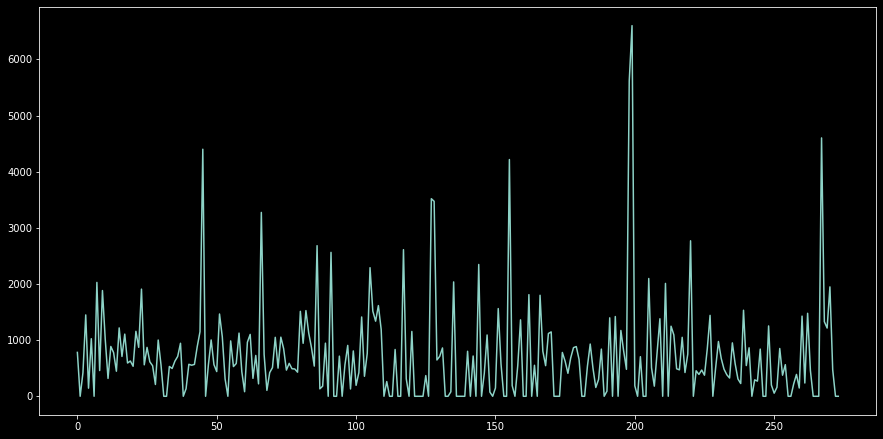

In [48]:
# Money for food of random client
cli = np.random.randint(0, unique_clients)

plt.plot(client_df[cli][0][:])

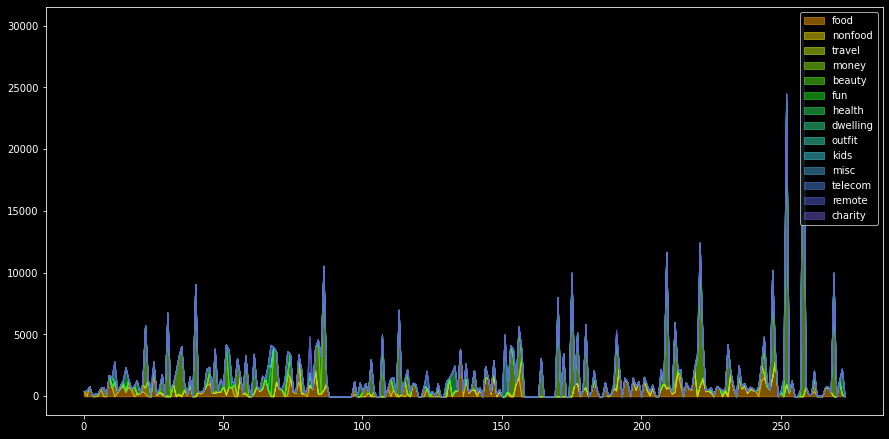

In [71]:
# Cumulative plot for different groups of one random client
cli = np.random.randint(0, unique_clients)

x = np.arange(0, num_days+1)
y = np.zeros(x.shape[0])
stack = [client_df[cli][n][:] for n in range(unique_groups)]

c = colors

for i, item in enumerate(stack):
    yp = np.copy(y)
    y += item
    plt.fill_between(x, yp, y, color=c[i], alpha=0.5)

plt.legend(tuple(group_list))

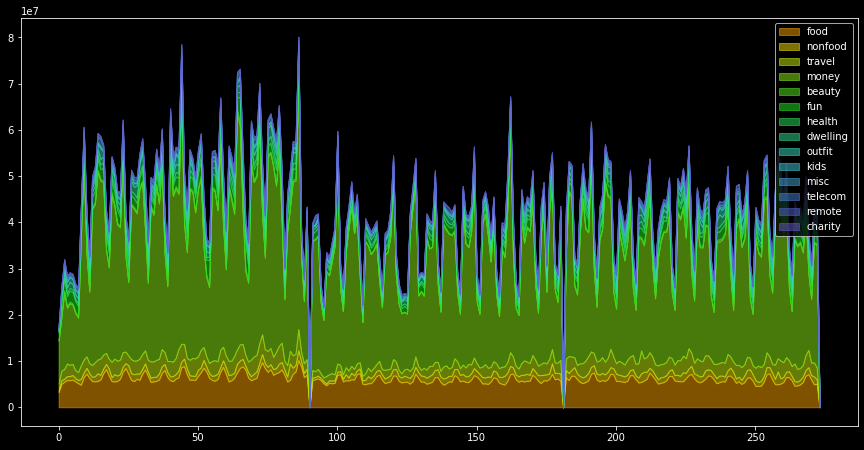

In [72]:
# Cumulative plot for different groups of all clients
client_sum = client_df.sum(axis=0).reshape(unique_groups, num_days+1)

x = np.arange(0, num_days+1)
y = np.zeros(x.shape[0])
stack = [client_sum[n][:] for n in range(unique_groups)]

c = colors

for i, item in enumerate(stack):
    yp = np.copy(y)
    y += item
    plt.fill_between(x, yp, y, color=c[i], alpha=0.5)

plt.legend(tuple(group_list))

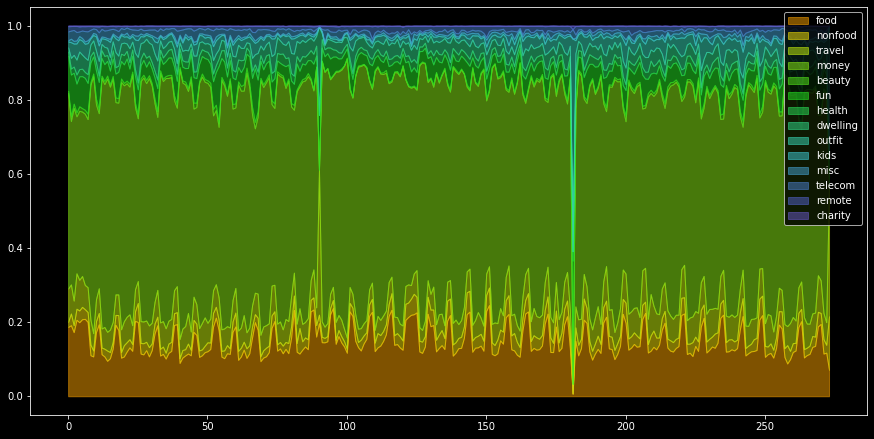

In [74]:
# Normalized cumulative plot for different groups of all clients
client_sum = client_df.sum(axis=0).reshape(unique_groups, num_days+1)
mega_sum = client_sum.sum(axis=0).reshape(num_days+1)

x = np.arange(0, num_days+1)
y = np.zeros(x.shape[0])
stack = [client_sum[n][:] for n in range(unique_groups)]

c = colors

for i, item in enumerate(stack):
    yp = np.copy(y)
    y += item
    plt.fill_between(x, yp/mega_sum, y/mega_sum, color=c[i], alpha=0.5)

plt.legend(tuple(group_list))